In [16]:
import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 80% 훈련, 10% 검증, 10% 테스트로 쪼개기
split_weights = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

(train_raw, val_raw, test_raw), metadata = tfds.load(
    'tf_flowers',
    split=split_weights,
    with_info=True,
    as_supervised=True,
)

print(f"훈련 데이터 개수: {len(train_raw)}")
print(f"검증 데이터 개수: {len(val_raw)}")
print(f"테스트 데이터 개수: {len(test_raw)}")

In [18]:
# 어떤 종류가 있는지 확인
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names

print(f"클래스 개수: {num_classes}")
print(f"꽃 종류: {class_names}")

클래스 개수: 5
꽃 종류: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


### resize & normalize 시행

In [19]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    # [-1, 1]로 정규화
    image = (image / 127.5) - 1
    # 크기 조절
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

# 훈련, 검증, 테스트 세트 모두에 동일하게 적용
train = train_raw.map(format_example)
validation = val_raw.map(format_example)
test = test_raw.map(format_example)

print("완료")

완료


2026-01-29 15:41:43.992768: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


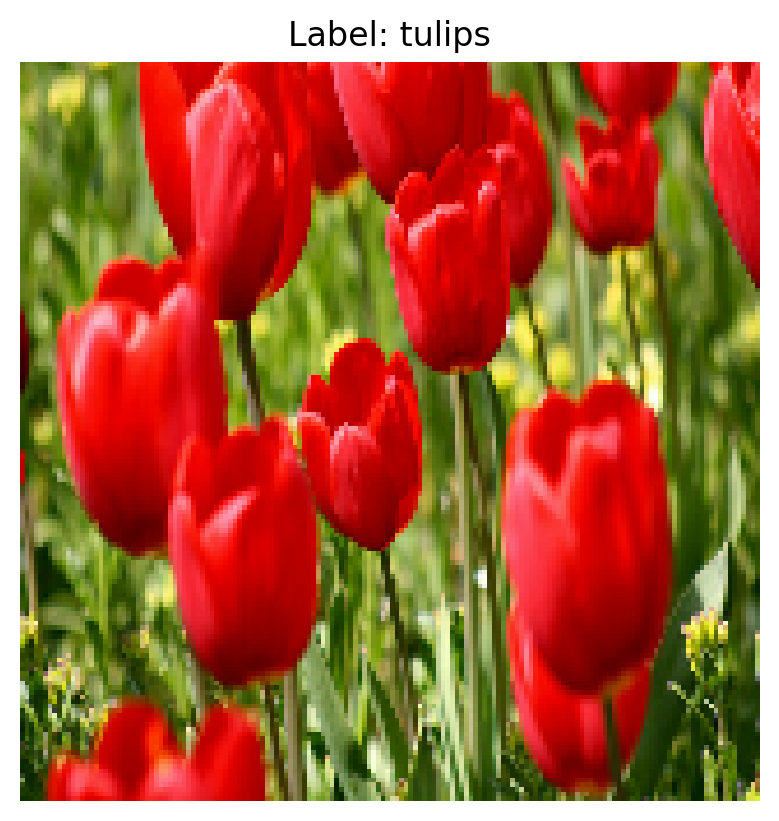

이미지 형태: (160, 160, 3)
최댓값: 1.00, 최솟값: -1.00


2026-01-29 15:41:44.047444: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
# 샘플 사진 하나로 확인
import matplotlib.pyplot as plt

for image, label in train.take(1):
    plt.imshow((image + 1) / 2) # 시각화를 위해 [-1, 1]을 다시 [0, 1]로 역산
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')
    plt.show()

    print(f"이미지 형태: {image.shape}")
    print(f"최댓값: {tf.reduce_max(image):.2f}, 최솟값: {tf.reduce_min(image):.2f}")

### Batching & Shuffling

In [22]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# Shuffle + Batch
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# 평가용이므로 섞지 않고 묶기만 함
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

print("데이터 묶기 완료")

데이터 묶기 완료


### VGG15으로 전이 학습

In [23]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG16 모델 가져오기
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

# VGG16 모델 convolution layer 그대로 사용
base_model.trainable = False

print("거인 모델 준비 완료!")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
거인 모델 준비 완료!


In [24]:
# classifier 추가
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax') # 꽃 종류 5개
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
# compile
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("컴파일 완료")

컴파일 완료


In [27]:
EPOCHS_1 = 5

# 첫 번째 학습 시도 (5에폭)
history = model.fit(
    train_batches,
    epochs=EPOCHS_1,
    validation_data=validation_batches
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 857ms/step - accuracy: 0.5140 - loss: 1.3838 - val_accuracy: 0.6512 - val_loss: 1.1380
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 891ms/step - accuracy: 0.7030 - loss: 1.0349 - val_accuracy: 0.7112 - val_loss: 0.8908
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 898ms/step - accuracy: 0.7446 - loss: 0.8520 - val_accuracy: 0.7275 - val_loss: 0.7747
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 912ms/step - accuracy: 0.7643 - loss: 0.7518 - val_accuracy: 0.7711 - val_loss: 0.7047
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 957ms/step - accuracy: 0.7837 - loss: 0.6840 - val_accuracy: 0.7820 - val_loss: 0.6536


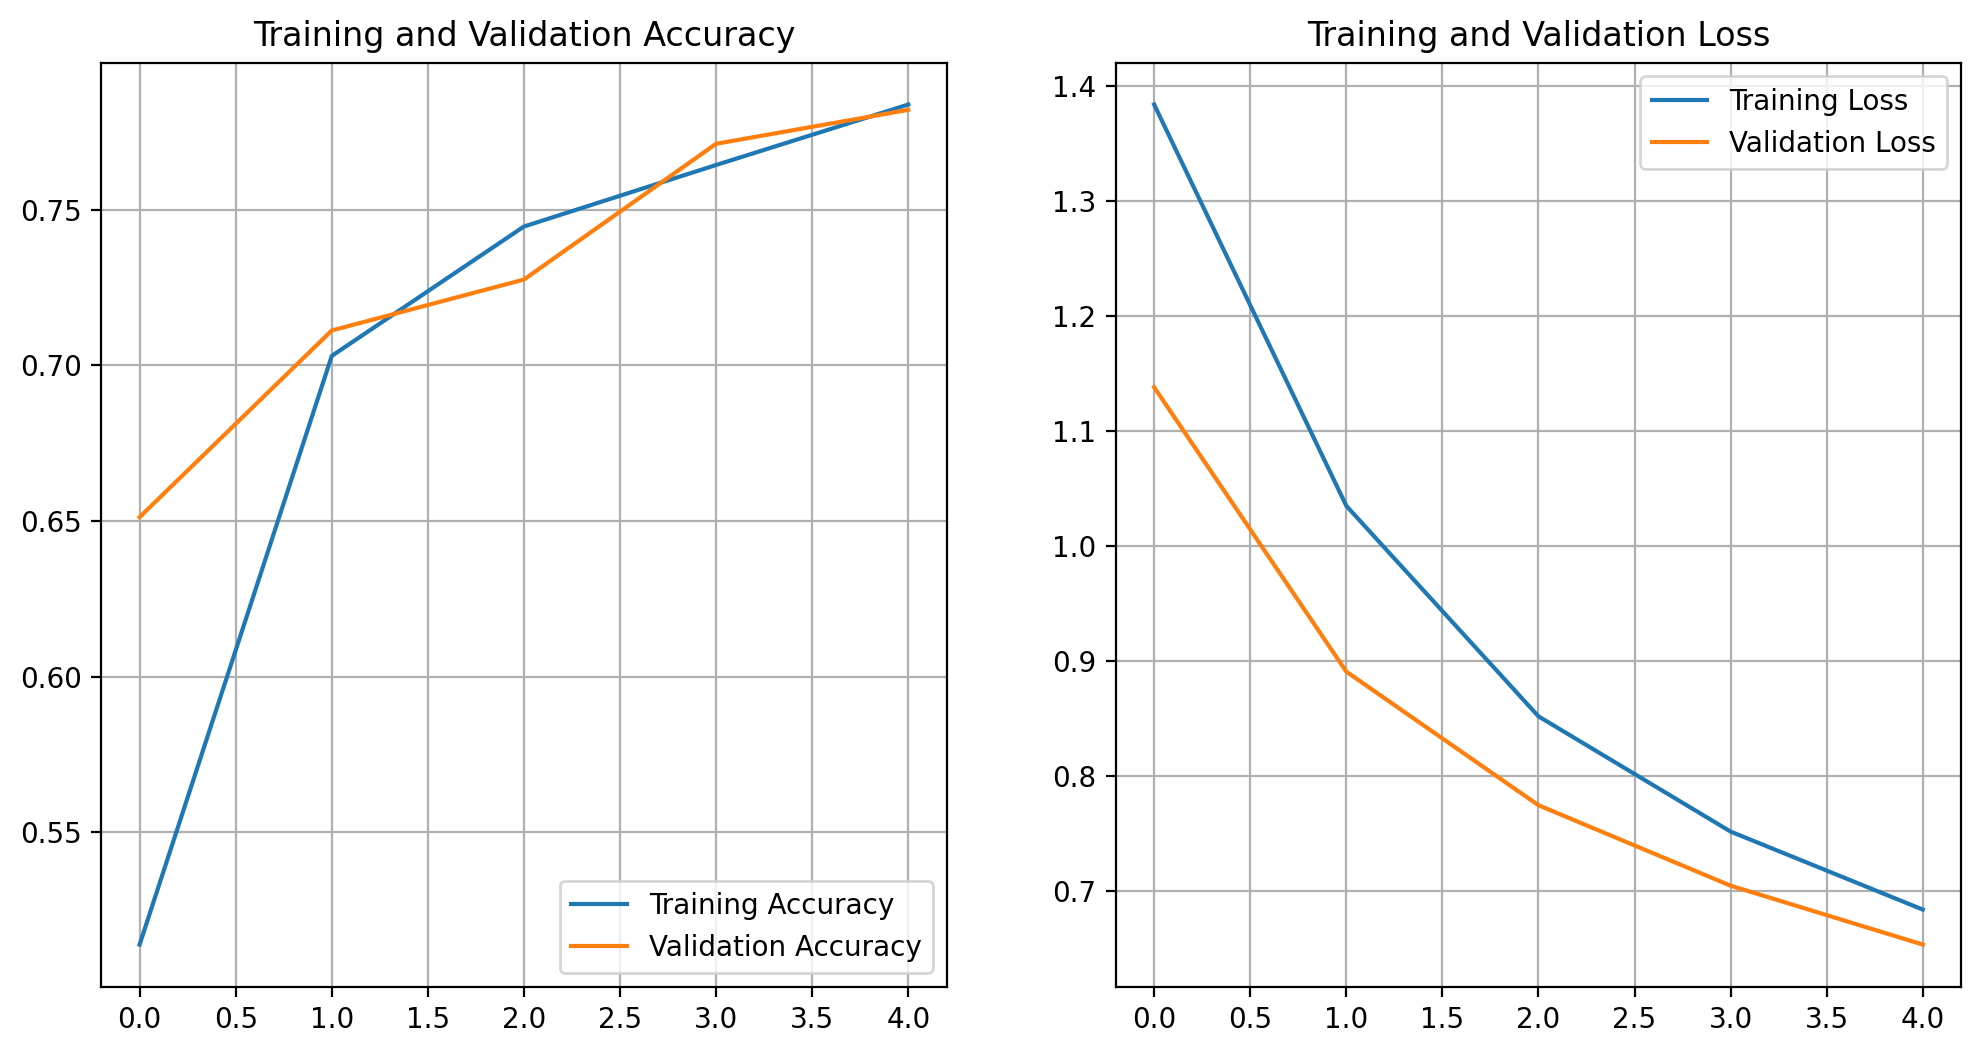

In [31]:
import matplotlib.pyplot as plt

def plot_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))

    # 1. 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # 2. 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

# 그래프 출력
plot_history(history, EPOCHS_1)

In [29]:
EPOCHS_2 = 10

# 처음부터 10에폭을 돌려 전체적인 흐름을 확인합니다.
history_vgg_10 = model.fit(
    train_batches,
    epochs=EPOCHS_2,
    validation_data=validation_batches
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 861ms/step - accuracy: 0.7987 - loss: 0.6346 - val_accuracy: 0.7684 - val_loss: 0.6350
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 880ms/step - accuracy: 0.8106 - loss: 0.5986 - val_accuracy: 0.7847 - val_loss: 0.5961
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 907ms/step - accuracy: 0.8205 - loss: 0.5695 - val_accuracy: 0.7984 - val_loss: 0.5765
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 883ms/step - accuracy: 0.8270 - loss: 0.5449 - val_accuracy: 0.7875 - val_loss: 0.5720
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 889ms/step - accuracy: 0.8304 - loss: 0.5231 - val_accuracy: 0.7929 - val_loss: 0.5523
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 897ms/step - accuracy: 0.8365 - loss: 0.5071 - val_accuracy: 0.8120 - val_loss: 0.5320
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.8454 - loss: 0.4892 - val_accuracy: 0.7956 - val_loss: 0.5325
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.8447 - loss: 0.4751 - val_accu

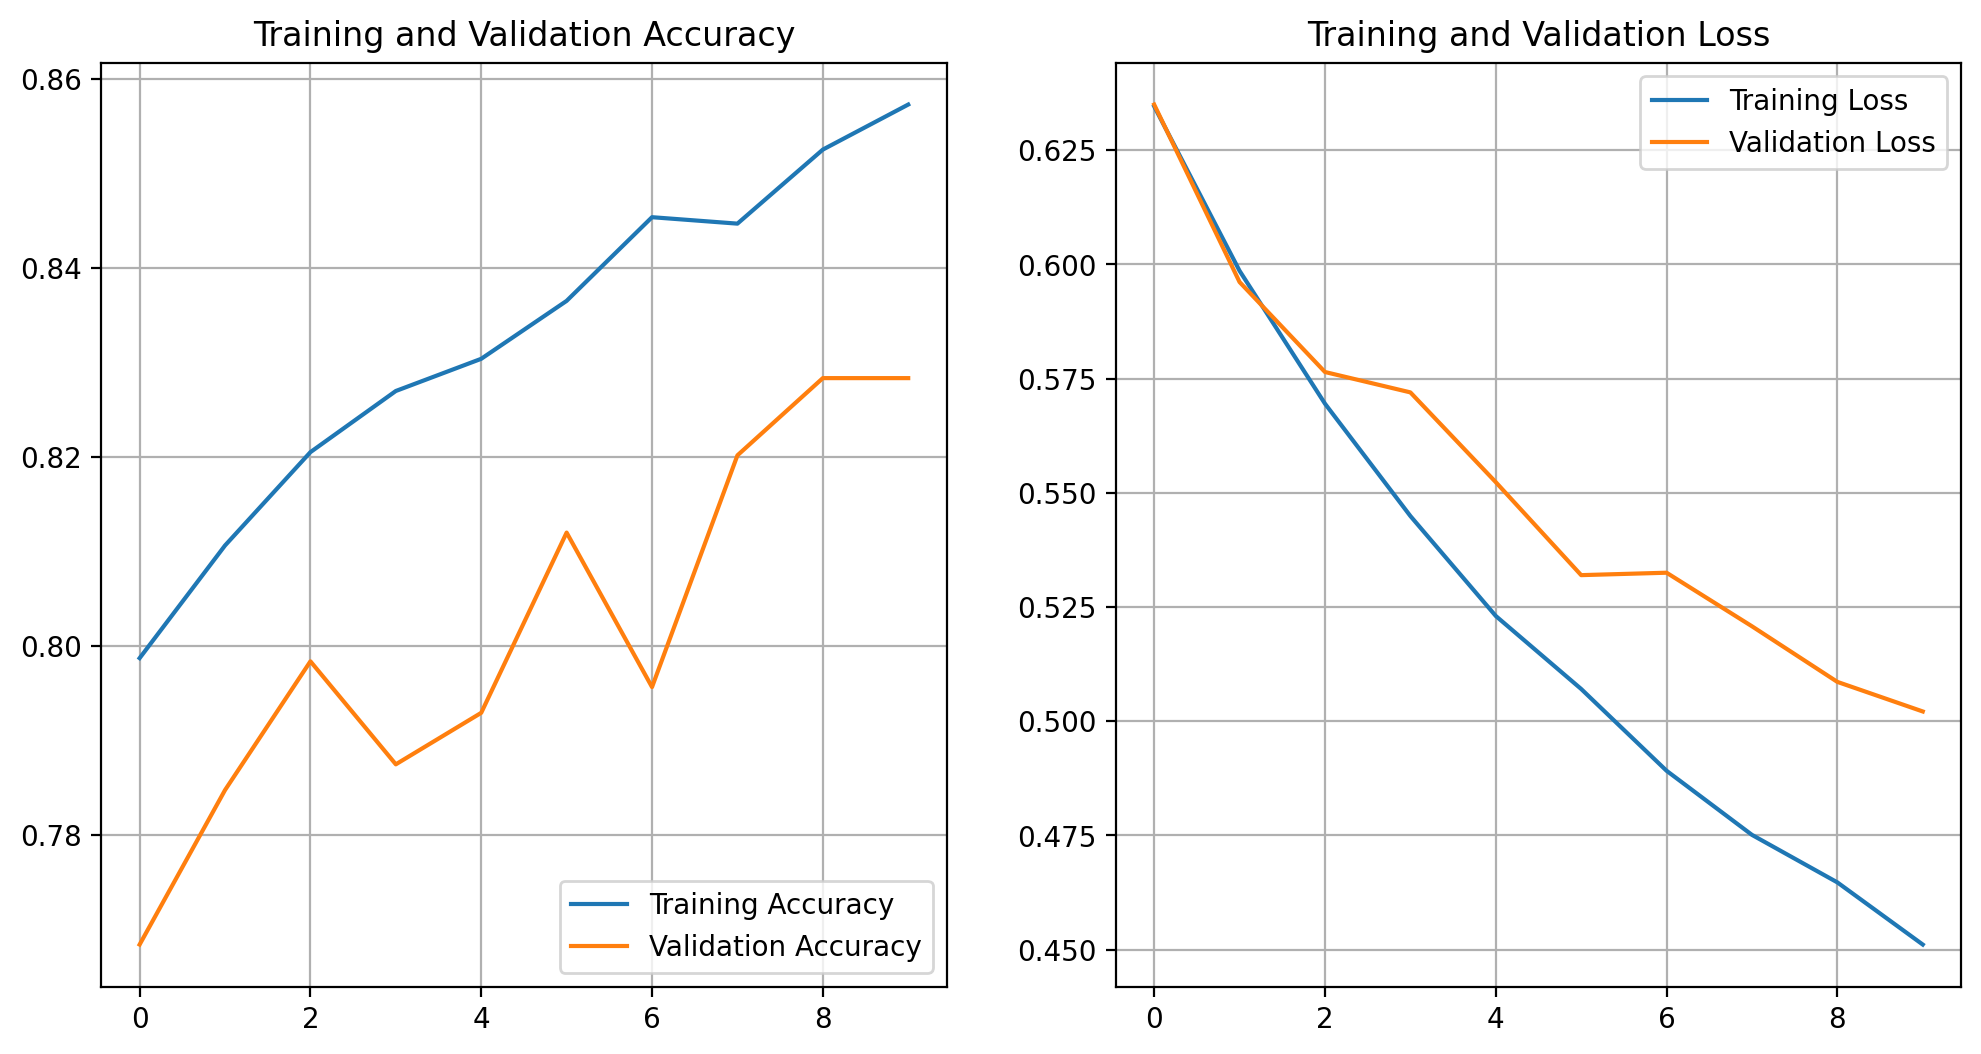

In [32]:
# 그래프 출력
plot_history(history_vgg_10, EPOCHS_2)

In [33]:
# 최종 test
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"최종 테스트 정확도: {test_accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 682ms/step - accuracy: 0.8420 - loss: 0.4850
최종 테스트 정확도: 84.20%


### EfficientNetB0 으로 전이학습

In [39]:
# EfficientNetB0 불러오기
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [40]:
# 모델 정의
model = tf.keras.Sequential([
  base_model,                        
  layers.GlobalAveragePooling2D(),   # 특징 요약
  layers.Dropout(0.5),               # dropout
  layers.Dense(5, activation='softmax') # 최종 5개 꽃 분류
])

In [41]:
# early stopping 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     
    patience=5,             # 5번의 에폭 기간 설정
    restore_best_weights=True # 가장 성적이 좋았던 때로 되돌아감
)

In [43]:
# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 에폭 10으로 학습
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.3168 - loss: 1.5690 - val_accuracy: 0.3324 - val_loss: 1.5609
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.2950 - loss: 1.5771 - val_accuracy: 0.3488 - val_loss: 1.5436
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.3082 - loss: 1.5642 - val_accuracy: 0.3651 - val_loss: 1.5093
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.3106 - loss: 1.5661 - val_accuracy: 0.2943 - val_loss: 1.5515
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.3110 - loss: 1.5576 - val_accuracy: 0.3488 - val_loss: 1.5377
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.3059 - loss: 1.5638 - val_accuracy: 0.3433 - val_loss: 1.5287
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.3093 - loss: 1.5587 - val_accuracy: 0.3406 - val_loss: 1.5377
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.3188 - loss: 1.5577 - val_accu

In [57]:
# EfficientNetB0에 Preprocessing이 포함되어 점수가 잘 늘지 않음
# 데이터 전처리부터 다시 진행

def format_example_new(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (160, 160))
    # EfficientNet은 내부적으로 Rescaling 층이 있어 0~255를 그대로 받습니다.
    return image, label

# 데이터셋에 다시 적용
BATCH_SIZE = 32
train_final = train_raw.map(format_example_new).shuffle(1000).batch(BATCH_SIZE)
validation_final = val_raw.map(format_example_new).batch(BATCH_SIZE)

In [58]:
# EfficientNetB0 불러오기
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [59]:
# 모델 정의
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [53]:
# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 에폭 10으로 학습
history = model.fit(
    train_final,
    epochs=10,
    validation_data=validation_final,
    callbacks=[early_stopping]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.6628 - loss: 0.9136 - val_accuracy: 0.8420 - val_loss: 0.4998
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.8430 - loss: 0.4839 - val_accuracy: 0.8801 - val_loss: 0.3829
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8682 - loss: 0.4048 - val_accuracy: 0.8828 - val_loss: 0.3335
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8873 - loss: 0.3511 - val_accuracy: 0.8856 - val_loss: 0.3072
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8913 - loss: 0.3272 - val_accuracy: 0.8965 - val_loss: 0.2844
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9002 - loss: 0.2956 - val_accuracy: 0.9046 - val_loss: 0.2783
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9009 - loss: 0.2825 - val_accuracy: 0.8965 - val_loss: 0.2660
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9046 - loss: 0.2705 - val_accu

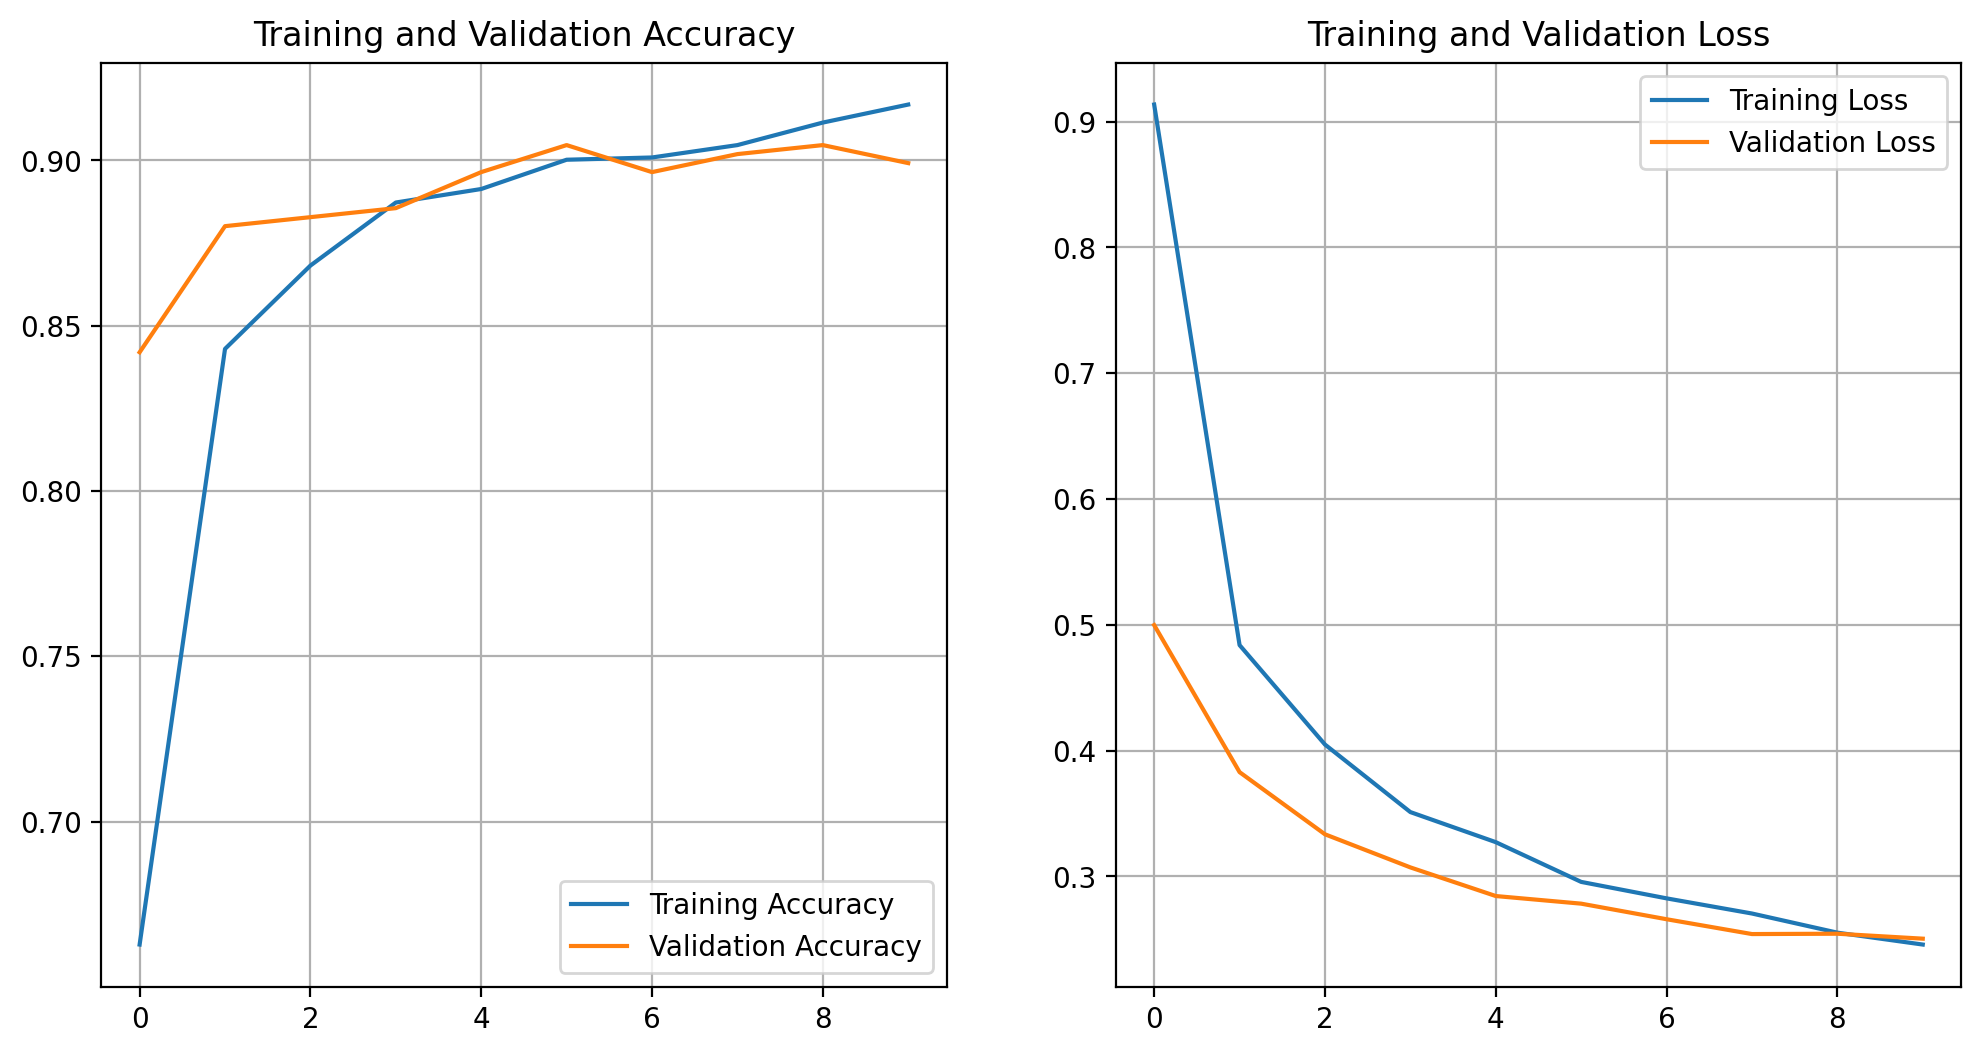

In [55]:
# 조기 종료 될 경우 해당 에폭 수 계산
actual_epochs = len(history.history['loss'])
plot_history(history, actual_epochs)

### 파인튜닝 시작

In [62]:
# 1차 시도
# model의 convolution layer를 그대로 학습하지 않고 조정하려고 True로 수정했습니다.
base_model.trainable = True

# EfficientNetB0의 전체 층에서 하위 100개 층은 기초 지식이니 놔두고, 상위 층들만 학습시킵니다. (총 230개가 있네요 ㅠ)
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 아주 낮은 학습률로 다시 컴파일 (기존 0.001 -> 0.00001)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 다시 학습
history_fine = model.fit(
    train_final,
    epochs=10,
    validation_data=validation_final,
    callbacks=[early_stopping]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.7071 - loss: 0.8332 - val_accuracy: 0.7929 - val_loss: 0.5874
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.7483 - loss: 0.7301 - val_accuracy: 0.8065 - val_loss: 0.5635
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.7718 - loss: 0.6594 - val_accuracy: 0.8202 - val_loss: 0.5311
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8059 - loss: 0.6039 - val_accuracy: 0.8256 - val_loss: 0.4972
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8205 - loss: 0.5497 - val_accuracy: 0.8338 - val_loss: 0.4697


In [63]:
# 2차 시도
# model의 convolution layer를 그대로 학습하지 않고 조정하려고 True로 수정했습니다.
base_model.trainable = True

# EfficientNetB0의 전체 층에서 하위 100개 층은 기초 지식이니 놔두고, 상위 층들만 학습시킵니다. (총 230개가 있네요 ㅠ)
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 아주 낮은 학습률로 다시 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 다시 학습
history_fine = model.fit(
    train_final,
    epochs=20,
    validation_data=validation_final,
    callbacks=[early_stopping]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.7452 - loss: 0.7293 - val_accuracy: 0.8147 - val_loss: 0.5581
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.7803 - loss: 0.6540 - val_accuracy: 0.8174 - val_loss: 0.5257
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7997 - loss: 0.6003 - val_accuracy: 0.8256 - val_loss: 0.4926
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8208 - loss: 0.5428 - val_accuracy: 0.8447 - val_loss: 0.4624
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8328 - loss: 0.5185 - val_accuracy: 0.8474 - val_loss: 0.4385


In [66]:
#3차 시도
# EfficientNetB0 불러오기
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

# 모델 정의
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 에폭 10으로 학습
history = model.fit(
    train_final,
    epochs=20,
    validation_data=validation_final,
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.6713 - loss: 0.9106 - val_accuracy: 0.8338 - val_loss: 0.4962
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8341 - loss: 0.4859 - val_accuracy: 0.8774 - val_loss: 0.3721
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8685 - loss: 0.4010 - val_accuracy: 0.8910 - val_loss: 0.3282
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.8852 - loss: 0.3449 - val_accuracy: 0.8910 - val_loss: 0.2966
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8890 - loss: 0.3197 - val_accuracy: 0.8965 - val_loss: 0.2806
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8971 - loss: 0.3005 - val_accuracy: 0.9019 - val_loss: 0.2651
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9118 - loss: 0.2676 - val_accuracy: 0.9019 - val_loss: 0.2547
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9087 - loss: 0.2688 - val_accura

In [67]:
# 테스트셋 전처리
test_final = test_raw.map(format_example_new).batch(BATCH_SIZE)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_final)

print(f"\n 최종 테스트 정확도: {test_accuracy * 100:.2f}%")
print(f"최종 테스트 손실도: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9319 - loss: 0.2111

 최종 테스트 정확도: 93.19%
최종 테스트 손실도: 0.2111


In [68]:
# 4차 시도
# EfficientNetB0 불러오기
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

# 모델 정의
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 에폭 15으로 학습
history = model.fit(
    train_final,
    epochs=15,
    validation_data=validation_final,
)


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.6775 - loss: 0.8795 - val_accuracy: 0.8501 - val_loss: 0.5099
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.8280 - loss: 0.4987 - val_accuracy: 0.8828 - val_loss: 0.3956
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8556 - loss: 0.4134 - val_accuracy: 0.8883 - val_loss: 0.3505
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8794 - loss: 0.3541 - val_accuracy: 0.8856 - val_loss: 0.3113
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8835 - loss: 0.3339 - val_accuracy: 0.8883 - val_loss: 0.2988
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.8985 - loss: 0.2901 - val_accuracy: 0.9019 - val_loss: 0.2793
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9053 - loss: 0.2860 - val_accuracy: 0.9074 - val_loss: 0.2667
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9097 - loss: 0.2678 - val_accu

In [69]:
# 테스트셋 전처리
test_final = test_raw.map(format_example_new).batch(BATCH_SIZE)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_final)

print(f"\n 최종 테스트 정확도: {test_accuracy * 100:.2f}%")
print(f"최종 테스트 손실도: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9264 - loss: 0.2195

 최종 테스트 정확도: 92.64%
최종 테스트 손실도: 0.2195
